In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import catboost as cb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
# import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
import random
import librosa, IPython
import librosa.display as lplt
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)
import warnings




k_folds = 5

seed = 12
np.random.seed(seed)
warnings.filterwarnings('ignore')
%matplotlib inline


TF version:- 2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [5]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()



Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,blues,1000
1,jazz,1000
2,metal,1000
3,pop,1000
4,reggae,1000
5,disco,999
6,classical,998
7,hiphop,998
8,rock,998
9,country,997


In [6]:

column_names = df.columns.tolist()
print(column_names)



['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label']


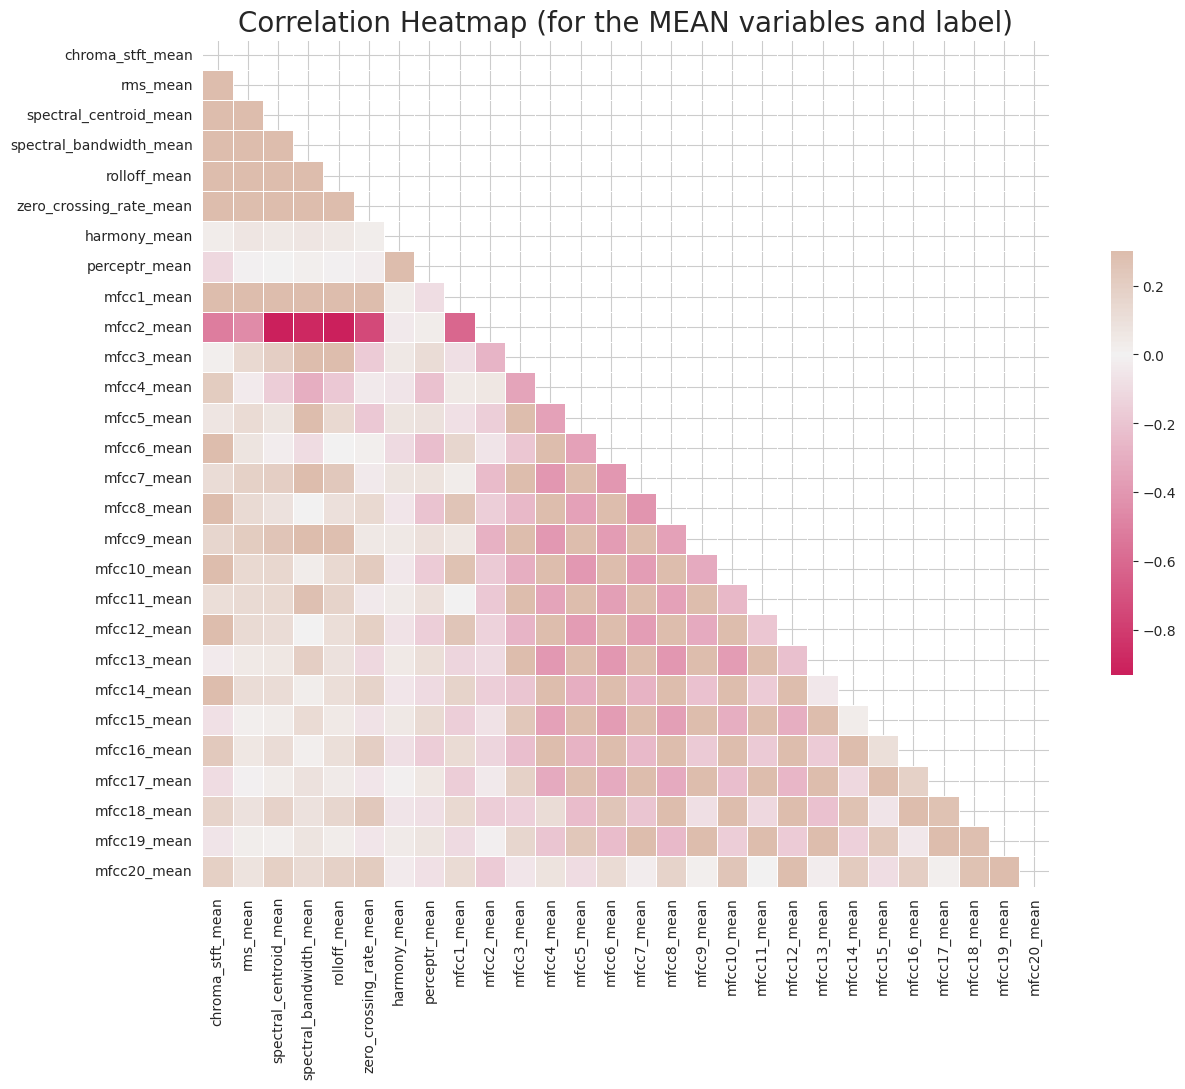

In [7]:
# Add the target variable to the list of columns
spike_cols = [col for col in df.columns if 'mean' in col] + ["label"]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables and label)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig("Corr_Heatmap_with_label.png")


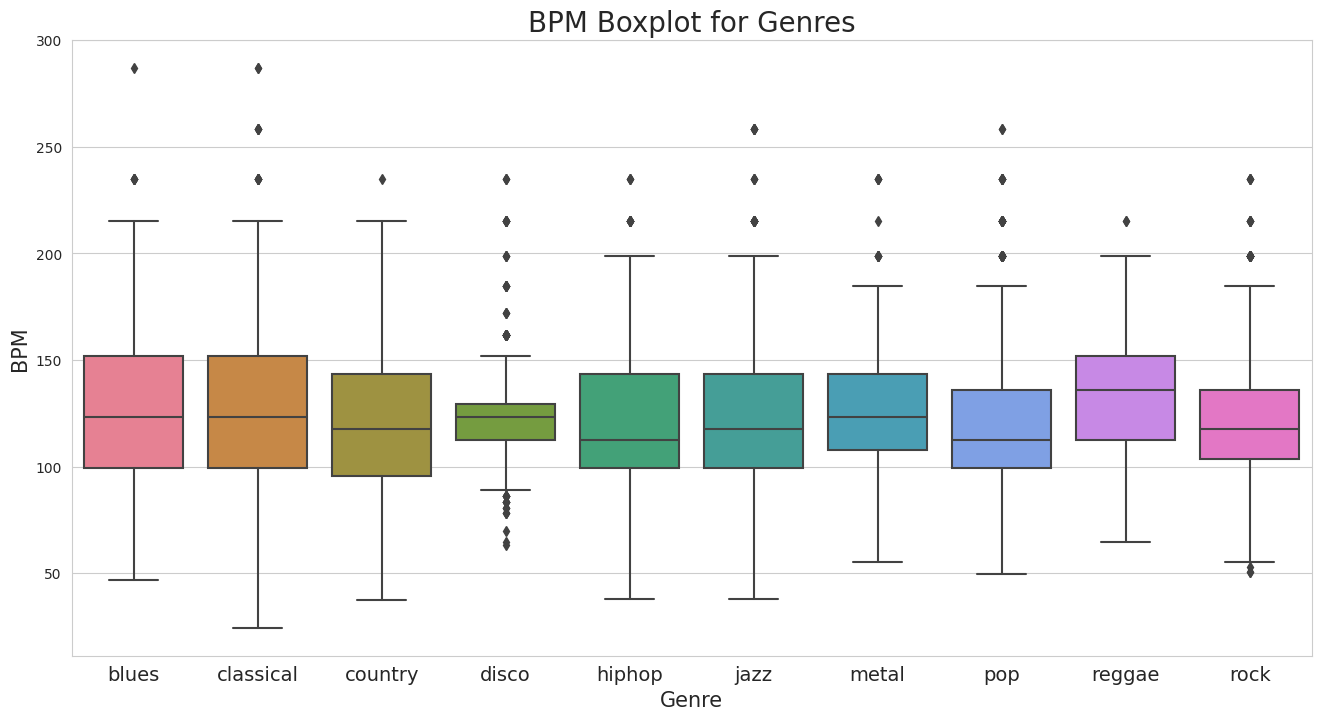

In [8]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")


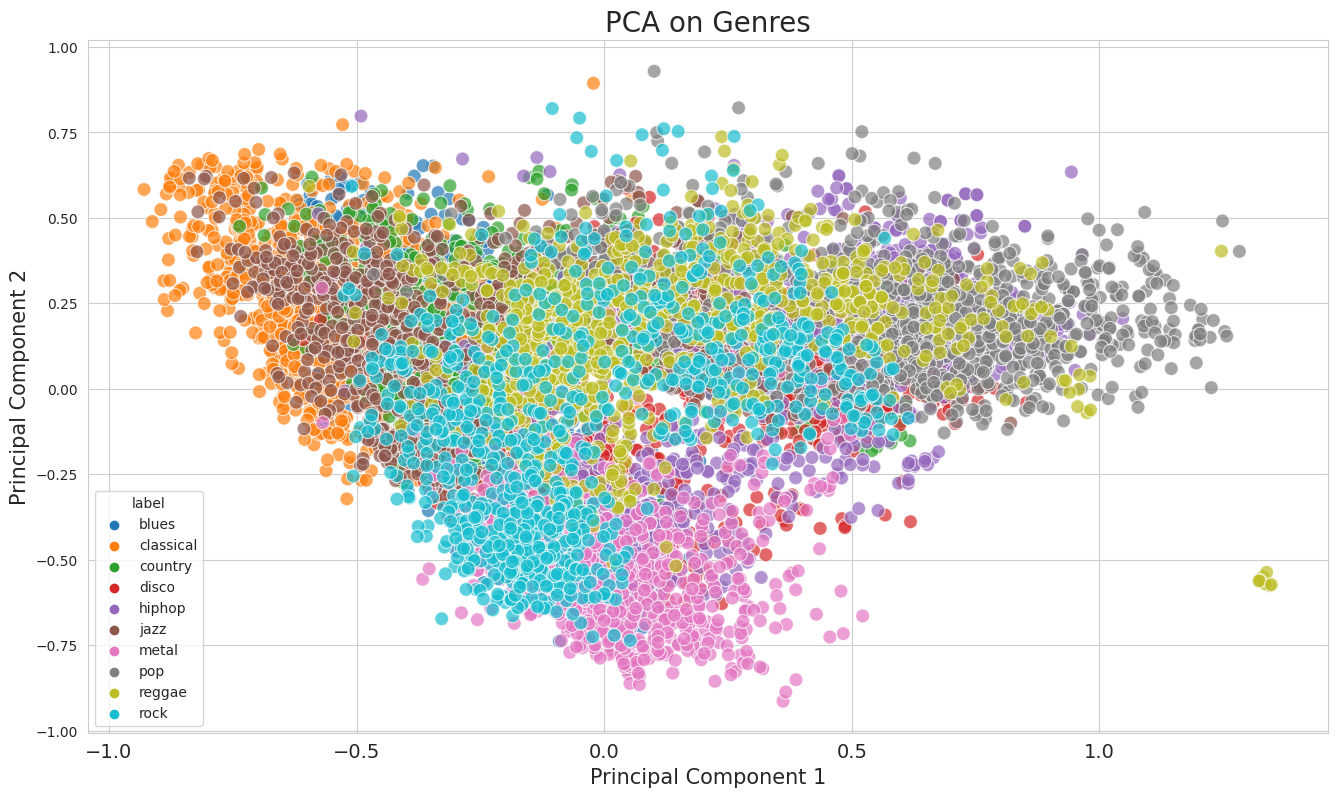

In [9]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

In [10]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))


Columns with NA values are []


In [11]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [12]:


# update labels in df to index
df.label = [label_index[l] for l in df.label]



In [13]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [14]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)


In [15]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [16]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


In [17]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [18]:
ACCURACY_THRESHOLD = 0.

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
       if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True


In [35]:

def trainModel(model, epochs, optimizer, train_index, val_index):
    # Set training parameters
    batch_size = 64
    callback = myCallback()
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')

    # Get the training and validation data for this fold
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_val_fold = y_train.iloc[val_index]

    # Train the CatBoost model
    catboost_model = cb.CatBoostClassifier(iterations=500, learning_rate=0.1, depth=5, loss_function='MultiClass', random_seed=seed)
    catboost_model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=False)
    catboost_accuracy = catboost_model.score(X_val_fold, y_val_fold)

    # Train the neural network model
    return model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=epochs,
                     batch_size=batch_size, callbacks=[callback, early_stopping]), X_val_fold, y_val_fold, catboost_accuracy, catboost_model


# Initialize lists to store the metrics
val_accuracies = []
confusion_matrices = []
val_accuracies_catboost = []

k_folds = 2  # validation cycles
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

fold = 1
for train_index, val_index in skf.split(X_train, y_train):
    print(f"Training on fold {fold}")

    # Define the neural network model
    model = k.models.Sequential([
        k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
        k.layers.Dropout(0.3),
        k.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        k.layers.Dropout(0.4),
        k.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        k.layers.Dropout(0.4),
        k.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        k.layers.Dropout(0.4),
        k.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        k.layers.Dropout(0.4),
        k.layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01)),
    ])

    # Train the model on this fold
    history, X_val_fold, y_val_fold, catboost_accuracy, catboost_model = trainModel(model=model, epochs=500, optimizer='adam', train_index=train_index, val_index=val_index)
    val_accuracies.append(max(history.history['val_accuracy']))
    val_accuracies_catboost.append(catboost_accuracy)

    # Generate predictions for the validation set
    y_pred = np.argmax(model.predict(X_val_fold), axis=-1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred)
    confusion_matrices.append(cm)

    fold += 1

# Print results
print("Mean CatBoost validation accuracy:", np.mean(val_accuracies_catboost))

print("Validation accuracies for each fold:", val_accuracies)
print("Mean validation accuracy:", np.mean(val_accuracies))

# Print confusion matrices
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion matrix for fold {i+1}:")
    print(cm)



Training on fold 1
Epoch 1/500
55/55 [==============================] - 4s 14ms/step - loss: 10.8693 - accuracy: 0.2346 - val_loss: 6.3886 - val_accuracy: 0.3512
Epoch 2/500
55/55 [==============================] - 0s 7ms/step - loss: 4.7264 - accuracy: 0.3570 - val_loss: 3.3730 - val_accuracy: 0.4341
Epoch 3/500
55/55 [==============================] - 0s 7ms/step - loss: 2.9843 - accuracy: 0.4065 - val_loss: 2.4731 - val_accuracy: 0.4495
Epoch 4/500
55/55 [==============================] - 0s 7ms/step - loss: 2.4063 - accuracy: 0.4348 - val_loss: 2.1304 - val_accuracy: 0.4784
Epoch 5/500
55/55 [==============================] - 0s 7ms/step - loss: 2.1571 - accuracy: 0.4591 - val_loss: 1.9564 - val_accuracy: 0.4970
Epoch 6/500
55/55 [==============================] - 0s 7ms/step - loss: 2.0241 - accuracy: 0.4760 - val_loss: 1.8797 - val_accuracy: 0.5265
Epoch 7/500
55/55 [==============================] - 0s 7ms/step - loss: 1.9842 - accuracy: 0.4897 - val_loss: 1.8340 - val_accuracy:

In [34]:
# Calculate and store the metrics
accuracies.append(accuracy_score(y_val_fold, y_pred))
precisions.append(precision_score(y_val_fold, y_pred, average='weighted'))
recalls.append(recall_score(y_val_fold, y_pred, average='weighted'))
f1_scores.append(f1_score(y_val_fold, y_pred, average='weighted'))
aucs.append(roc_auc_score(y_val_fold, catboost_model.predict_proba(X_val_fold), multi_class='ovr', average='weighted'))

# Create a dictionary with the mean values of the metrics
mean_metrics = {
    'Mean CV Score': [np.mean(val_accuracies_catboost)],
    'Accuracy': [np.mean(accuracies)],
    'Precision': [np.mean(precisions)],
    'Recall': [np.mean(recalls)],
    'F1 Score': [np.mean(f1_scores)],
    'AUC': [np.mean(aucs)]
}

# Create a pandas DataFrame to display the table
metrics_table = pd.DataFrame(mean_metrics, columns=['Mean CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
print(metrics_table)


   Mean CV Score  Accuracy  Precision    Recall  F1 Score       AUC
0       0.822394  0.749428   0.748428  0.749428  0.746941  0.982343


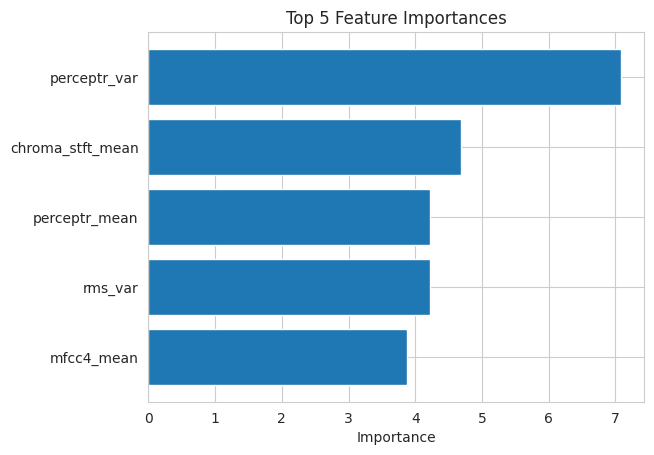

In [36]:
# Get the top 5 most important features
top_features = sorted_feature_importance[:5]

# Separate the feature names and their importances into separate lists
feature_names, importances = zip(*top_features)

# Plot the histogram
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Top 5 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [22]:
def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

Max. Validation Accuracy 0.7734553813934326


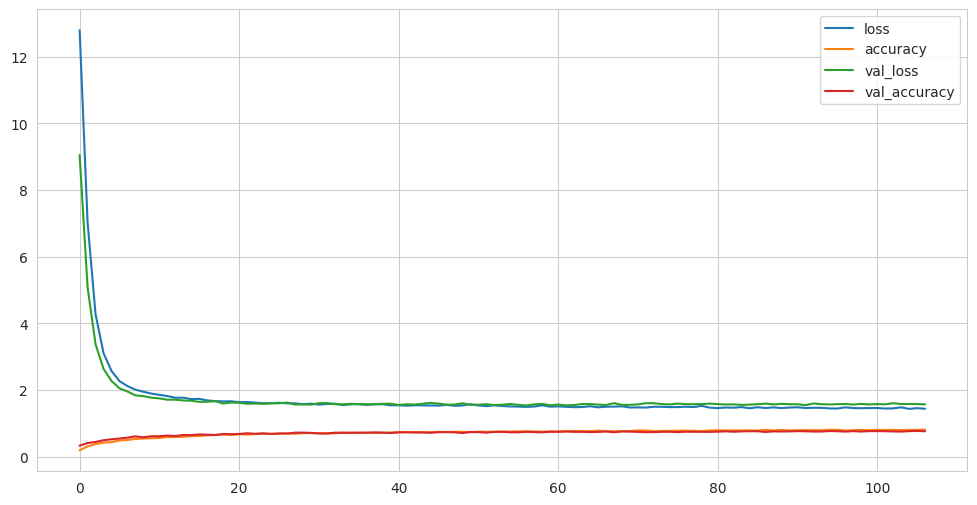

In [23]:
plotHistory(history)

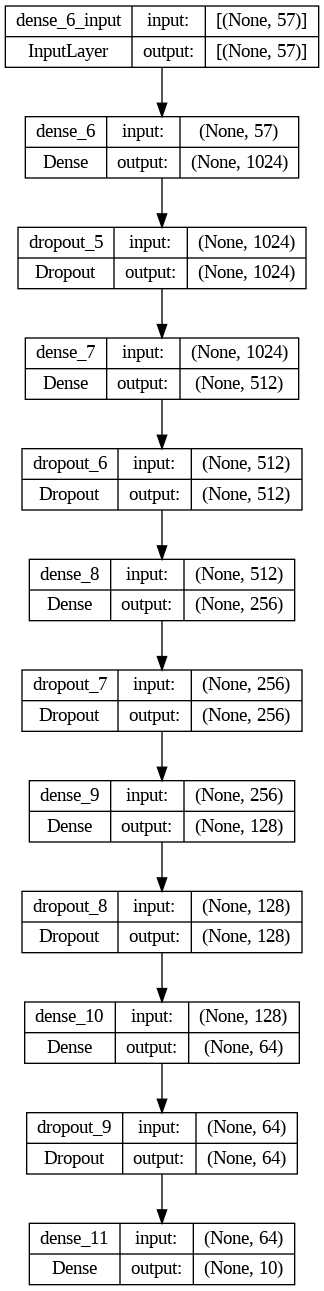

In [24]:
# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [25]:
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)


8/8 [==============================] - 0s 8ms/step - loss: 1.5253 - accuracy: 0.7478
The test Loss is : 1.5252519845962524

The Best test Accuracy is : 74.77919459342957


In [26]:

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)


32/32 [==============================] - 0s 3ms/step


In [27]:
dict2 = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
predicted_values = pd.DataFrame(predicted_labels, columns=['label'])
predicted_values = predicted_values.replace({"label": dict2})
predicted_values.reset_index(drop=True, inplace=True)
predicted_values_list = list(predicted_values.label)
i = 0
for item in predicted_values_list:
    print("The prediction of song no. {} in our dataset is {}".format(i, item))
    i = i + 1


The prediction of song no. 0 in our dataset is metal
The prediction of song no. 1 in our dataset is jazz
The prediction of song no. 2 in our dataset is jazz
The prediction of song no. 3 in our dataset is classical
The prediction of song no. 4 in our dataset is metal
The prediction of song no. 5 in our dataset is jazz
The prediction of song no. 6 in our dataset is classical
The prediction of song no. 7 in our dataset is pop
The prediction of song no. 8 in our dataset is hiphop
The prediction of song no. 9 in our dataset is jazz
The prediction of song no. 10 in our dataset is metal
The prediction of song no. 11 in our dataset is blues
The prediction of song no. 12 in our dataset is pop
The prediction of song no. 13 in our dataset is jazz
The prediction of song no. 14 in our dataset is jazz
The prediction of song no. 15 in our dataset is pop
The prediction of song no. 16 in our dataset is metal
The prediction of song no. 17 in our dataset is hiphop
The prediction of song no. 18 in our dat